In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
# загружаем датафрейм:
df = pd.read_csv(r'C:\project\data.csv')

In [3]:
# Смотрим первые 5 строк для первичной оценки данных
df.head(5)

,client_id,sum,status,sale,new/current,Unnamed: 5,document,receiving_date
0,NaN,NaN,Май 2021,NaN,NaN,NaN,NaN,NaN
1,6.0,"11 693,70",ВНУТРЕННИЙ,-,-,NaN,-,-
2,14.0,"5 452,70",ОПЛАЧЕНО,Петрова,новая,NaN,оригинал,26.07.21
3,15.0,"13 991,70",ОПЛАЧЕНО,Иванов,текущая,NaN,оригинал,08.06.21
4,16.0,"719,7",ОПЛАЧЕНО,Иванов,текущая,NaN,оригинал,08.06.21


При помощи info посмотрим, на пропуски и типы данных в столбцах:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       724 non-null    float64
 1   sum             724 non-null    object 
 2   status          730 non-null    object 
 3   sale            724 non-null    object 
 4   new/current     724 non-null    object 
 5   Unnamed: 5      0 non-null      float64
 6   document        709 non-null    object 
 7   receiving_date  607 non-null    object 
dtypes: float64(2), object(6)
memory usage: 45.8+ KB


Видим следующие проблемы:
- Совершенно бесполезный столбец `Unnamed: 5`, не несущий никаких данных;
- Пропуски во всех столбцах, кроме `status`. Особенно много пропусков, не считая совсем пустого `Unnamed: 5`, в `receiving_date`;
- У столбца `new/current` не совсем корректное название - лучше переделать его под питоний регистр, так как слеш внутри может мешать делать срезы;
- В столбцах неверные типы данных: `client_id` явно должен быть *int*, `sum` - не строкой, а *float*, в столбце `receiving_date` всё, что можно, надо привести к типу *datetime*.

Для начала удалим ненужный столбец `Unnamed: 5`:

In [5]:
df = df.drop('Unnamed: 5', axis=1)

Теперь переименуем столбец `new/current`:

In [6]:
df = df.rename(columns={'new/current': 'new_current'})
df.head(5)

,client_id,sum,status,sale,new_current,document,receiving_date
0,NaN,NaN,Май 2021,NaN,NaN,NaN,NaN
1,6.0,"11 693,70",ВНУТРЕННИЙ,-,-,-,-
2,14.0,"5 452,70",ОПЛАЧЕНО,Петрова,новая,оригинал,26.07.21
3,15.0,"13 991,70",ОПЛАЧЕНО,Иванов,текущая,оригинал,08.06.21
4,16.0,"719,7",ОПЛАЧЕНО,Иванов,текущая,оригинал,08.06.21


Переименование состоялось.

Взглянем на уникальные значения столбца `status` и еще раз вызовем первые 5 строк датафрейма:

In [7]:
display(df.head(5))
df.status.unique()

,client_id,sum,status,sale,new_current,document,receiving_date
0,NaN,NaN,Май 2021,NaN,NaN,NaN,NaN
1,6.0,"11 693,70",ВНУТРЕННИЙ,-,-,-,-
2,14.0,"5 452,70",ОПЛАЧЕНО,Петрова,новая,оригинал,26.07.21
3,15.0,"13 991,70",ОПЛАЧЕНО,Иванов,текущая,оригинал,08.06.21
4,16.0,"719,7",ОПЛАЧЕНО,Иванов,текущая,оригинал,08.06.21


array(['Май 2021', 'ВНУТРЕННИЙ', 'ОПЛАЧЕНО', 'ПРОСРОЧЕНО', 'Июнь 2021',
       'Июль 2021', 'Август 2021', 'В РАБОТЕ', 'Сентябрь 2021',
       'Октябрь 2021', 'НА ПОДПИСАНИИ'], dtype=object)

В столбце `status` есть 6 значений с наименованиями месяцев, а-ля Май 2021. Все строки с этими значениями пустые - вот и ответ откуда в столбцах  `client_id`, `sum` и `sale` 6 "пропусков". На самом деле пропусков в этих столбцах нет.

Удалять строки с месяцами нельзя - дат продаж у нас нет. Есть только дата получения оригинала договора, которая может не совпадать с месяцем продажи. А эти строки позволят нам понимать в каком временном промежутке прошла та или иная сделка.

Настоящие же пропуски есть в столбцах:
- `document` - тут пропусков больше 6. Их можно заполнить словом "*Нет*", поскольку оригиналов, скорее всего, действительно на руках при таком статусе нет;
- `receiving_date` - здесь мы ничего, кроме удаления пропусков, не сможем сделать. Однако для начала посмотрим целесообразно ли это удаление -  если пропусков больше 10%, потеряем значительное количество данных и это может исказить анализ.

In [8]:
display('% Пропусков:', df.isna().mean()*100)

'% Пропусков:'

client_id          0.821918
sum                0.821918
status             0.000000
sale               0.821918
new_current        0.821918
document           2.876712
receiving_date    16.849315
dtype: float64

Почти 17%. Оставим столбец `receiving_date` как есть.

`document` в местах пропусков заполним "НЕТ":

In [9]:
df.document = df.document.fillna('НЕТ')
df.document.unique()

array(['НЕТ', '-', 'оригинал'], dtype=object)

Пропуски в `document` заменены.

Теперь изменим тип данных в столбце `receiving_date` там, где это возможно. Поскольку столбец содержит пропуски и значения типа '-', будем преобразовывать через функцию, которая на входе будет получать значение из столбца и если это не пропуск и не '-', будет возвращать данные в формате даты. В противном же случае вернет, что есть:

In [10]:
def time_type(x):
    if x != '-' and x != np.nan:
        return pd.to_datetime(x, format='%d.%m.%y')
    else:
        return x

# Применяем функцию к столбцу + сразу преобразовываем в нужный тип:
df['receiving_date'] = df['receiving_date'].apply(time_type)
df.head(5)

,client_id,sum,status,sale,new_current,document,receiving_date
0,NaN,NaN,Май 2021,NaN,NaN,НЕТ,NaT
1,6.0,"11 693,70",ВНУТРЕННИЙ,-,-,-,-
2,14.0,"5 452,70",ОПЛАЧЕНО,Петрова,новая,оригинал,2021-07-26 00:00:00
3,15.0,"13 991,70",ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00
4,16.0,"719,7",ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00


Преобразование прошло корректно.

Теперь поменяем тип данных в столбце `client_id`. Так как у нас здесь есть пропуски из пометок месяцев в `status`, просто заполним их нулями - поскольку `client_id` в таком случае действительно неизвестно-нулевой. В таком случае можно будет применить astype для преобразования и не шаманить с дополнительными пользовательскими функциями:

In [11]:
df.client_id = df.client_id.fillna(0).astype('int')
df.head(5)

,client_id,sum,status,sale,new_current,document,receiving_date
0,0,NaN,Май 2021,NaN,NaN,НЕТ,NaT
1,6,"11 693,70",ВНУТРЕННИЙ,-,-,-,-
2,14,"5 452,70",ОПЛАЧЕНО,Петрова,новая,оригинал,2021-07-26 00:00:00
3,15,"13 991,70",ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00
4,16,"719,7",ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00


В столбце `sum` данные записаны как строки. Сразу во `float` мы их не переделаем - мешают пробелы и запятые. Сначала почистим данные от "мусора", а потом уже проведем преобразование:

In [12]:
df['sum'] = df['sum'].replace('\s', '', regex=True).replace(r',', '.', regex=True).astype('float')
df['sum']

0          NaN
1      11693.7
2       5452.7
3      13991.7
4        719.7
        ...   
725     4328.7
726     3096.2
727     3096.2
728     4403.7
729     3978.7
Name: sum, Length: 730, dtype: float64

Теперь в столбце `sum` корректный тип данных, с которым можно проводить дальнейшие вычисления.

Также, для нужд анализа добавим в датафрейм столбец с месяцем получения договора:

In [13]:
def get_month(x):
    if x != '-' and x != np.nan:
        return x.month
    else:
        return x

# Применяем функцию к столбцу + сразу преобразовываем в нужный тип:
df['month'] = df['receiving_date'].apply(get_month)
df.head(10)

,client_id,sum,status,sale,new_current,document,receiving_date,month
0,0,NaN,Май 2021,NaN,NaN,НЕТ,NaT,NaN
1,6,11693.7,ВНУТРЕННИЙ,-,-,-,-,-
2,14,5452.7,ОПЛАЧЕНО,Петрова,новая,оригинал,2021-07-26 00:00:00,7
3,15,13991.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00,6
4,16,719.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00,6
5,18,4253.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-07-07 00:00:00,7
6,20,5796.7,ОПЛАЧЕНО,Кузнецова,текущая,оригинал,2021-07-15 00:00:00,7
7,21,3613.7,ОПЛАЧЕНО,Кузнецова,текущая,оригинал,2021-10-13 00:00:00,10
8,23,8511.7,ОПЛАЧЕНО,Андреев,текущая,оригинал,2021-06-08 00:00:00,6
9,24,16347.7,ОПЛАЧЕНО,Андреев,новая,оригинал,2021-06-23 00:00:00,6


Столбец на месте и отображает корректные данные.

Также, для решения дальнейших заданий датафрейм было решено разбить на 6 частей - по строкам с месяцами, которые делят данные. Для этого нужно знать индексы этих строк. Индекс мая нам уже известен - это 0. А индексы остальных достанем так:  

In [14]:
print('Данные июня начинаются тут:', df[df['status'] == 'Июнь 2021'].index)
print('Данные июля начинаются тут:', df[df['status'] == 'Июль 2021'].index)
print('Данные августа начинаются тут:', df[df['status'] == 'Август 2021'].index)
print('Данные сентября начинаются тут:', df[df['status'] == 'Сентябрь 2021'].index)
print('Данные октября начинаются тут:', df[df['status'] == 'Октябрь 2021'].index)

Данные июня начинаются тут: Int64Index([129], dtype='int64')
Данные июля начинаются тут: Int64Index([258], dtype='int64')
Данные августа начинаются тут: Int64Index([369], dtype='int64')
Данные сентября начинаются тут: Int64Index([484], dtype='int64')
Данные октября начинаются тут: Int64Index([594], dtype='int64')


Теперь, когда мы знаем начало данных для каждого из месяцев, из главного датафрейма вырежем информацию по каждому конкретному периоду в отдельную переменную. При этом для удобства сделаем это так, чтобы строки со, скажем, *Июнь 2021* в таблицы не попали + переименуем в каждом столбец `sum` в *название месяца + sales* - так в дальнейшем будет легче с графиками.

Это данные для мая:

In [15]:
may = df.iloc[1:129].rename(columns={'sum': 'may_sales'})
may

,client_id,may_sales,status,sale,new_current,document,receiving_date,month
1,6,11693.7,ВНУТРЕННИЙ,-,-,-,-,-
2,14,5452.7,ОПЛАЧЕНО,Петрова,новая,оригинал,2021-07-26 00:00:00,7
3,15,13991.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00,6
4,16,719.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00,6
5,18,4253.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-07-07 00:00:00,7
...,...,...,...,...,...,...,...,...
124,277,4623.7,ОПЛАЧЕНО,Филимонова,текущая,оригинал,2021-07-14 00:00:00,7
125,281,4488.7,ОПЛАЧЕНО,Селиванов,новая,оригинал,2021-07-16 00:00:00,7
126,284,8903.7,ПРОСРОЧЕНО,Филимонова,текущая,оригинал,2021-07-27 00:00:00,7
127,286,3453.7,ОПЛАЧЕНО,Филимонова,текущая,оригинал,2021-05-31 00:00:00,5


Данные для июня:

In [16]:
june = df.iloc[130:258].rename(columns={'sum': 'june_sales'})
june

,client_id,june_sales,status,sale,new_current,document,receiving_date,month
130,316,35653.7,ОПЛАЧЕНО,Петрова,новая,оригинал,2021-08-09 00:00:00,8
131,15,13518.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-07-09 00:00:00,7
132,16,985.3,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-07-09 00:00:00,7
133,18,2996.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-09-09 00:00:00,9
134,21,4233.7,ОПЛАЧЕНО,Кузнецова,текущая,оригинал,2021-09-17 00:00:00,9
...,...,...,...,...,...,...,...,...
253,281,5733.7,ОПЛАЧЕНО,Селиванов,текущая,оригинал,2021-07-22 00:00:00,7
254,282,953.7,ОПЛАЧЕНО,Селиванов,новая,оригинал,2021-07-16 00:00:00,7
255,284,8823.7,ПРОСРОЧЕНО,Филимонова,текущая,оригинал,2021-09-08 00:00:00,9
256,286,3453.7,ОПЛАЧЕНО,Филимонова,текущая,оригинал,2021-07-22 00:00:00,7


Данные для июля:

In [17]:
july = df.iloc[259:369].rename(columns={'sum': 'july_sales'})
july

,client_id,july_sales,status,sale,new_current,document,receiving_date,month
259,15,13838.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-08-09 00:00:00,8
260,16,1586.5,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-08-09 00:00:00,8
261,18,2996.7,ОПЛАЧЕНО,Иванов,текущая,НЕТ,NaT,NaN
262,21,4313.7,ОПЛАЧЕНО,Кузнецова,текущая,оригинал,2021-09-17 00:00:00,9
263,24,19407.7,ОПЛАЧЕНО,Андреев,текущая,оригинал,2021-08-19 00:00:00,8
...,...,...,...,...,...,...,...,...
364,277,4878.7,ОПЛАЧЕНО,Филимонова,текущая,оригинал,2021-08-03 00:00:00,8
365,281,11703.7,ОПЛАЧЕНО,Селиванов,текущая,оригинал,2021-08-13 00:00:00,8
366,284,1977.7,ПРОСРОЧЕНО,Филимонова,текущая,НЕТ,NaT,NaN
367,286,4048.7,ОПЛАЧЕНО,Филимонова,текущая,оригинал,2021-08-11 00:00:00,8


Данные для августа:

In [18]:
august = df.iloc[370:484].rename(columns={'sum': 'august_sales'})
august

,client_id,august_sales,status,sale,new_current,document,receiving_date,month
370,15,13838.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-09-09 00:00:00,9
371,16,1845.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-09-09 00:00:00,9
372,21,4153.7,ОПЛАЧЕНО,Кузнецова,текущая,оригинал,2021-10-13 00:00:00,10
373,24,18052.7,ОПЛАЧЕНО,Андреев,текущая,оригинал,2021-09-27 00:00:00,9
374,30,3833.7,ОПЛАЧЕНО,Филимонова,текущая,оригинал,2021-09-27 00:00:00,9
...,...,...,...,...,...,...,...,...
479,303,22413.7,ОПЛАЧЕНО,Андреев,новая,оригинал,2021-09-10 00:00:00,9
480,304,1783.7,ОПЛАЧЕНО,Андреев,новая,оригинал,2021-09-10 00:00:00,9
481,285,3423.7,ОПЛАЧЕНО,Васильев,новая,оригинал,2021-09-02 00:00:00,9
482,286,3678.7,ОПЛАЧЕНО,Филимонова,текущая,оригинал,2021-09-21 00:00:00,9


Данные для сентября:

In [19]:
september = df.iloc[485:594].rename(columns={'sum': 'september_sales'})
september

,client_id,september_sales,status,sale,new_current,document,receiving_date,month
485,15,14288.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-10-08 00:00:00,10
486,16,1494.0,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-10-08 00:00:00,10
487,21,893.7,ОПЛАЧЕНО,Кузнецова,текущая,оригинал,2021-10-20 00:00:00,10
488,24,18142.7,ОПЛАЧЕНО,Андреев,текущая,НЕТ,2021-10-15 00:00:00,10
489,30,3833.7,В РАБОТЕ,Филимонова,текущая,НЕТ,NaT,NaN
...,...,...,...,...,...,...,...,...
589,304,1313.7,ОПЛАЧЕНО,Андреев,текущая,оригинал,2021-10-13 00:00:00,10
590,285,3453.7,ОПЛАЧЕНО,Васильев,текущая,оригинал,2021-10-05 00:00:00,10
591,285,4328.7,ОПЛАЧЕНО,Васильев,новая,оригинал,2021-10-05 00:00:00,10
592,286,4078.7,ОПЛАЧЕНО,Филимонова,текущая,оригинал,2021-10-20 00:00:00,10


Данные для октября:

In [20]:
october = df.iloc[595:].rename(columns={'sum': 'october_sales'})
october

,client_id,october_sales,status,sale,new_current,document,receiving_date,month
595,15,14591.7,В РАБОТЕ,Иванов,текущая,оригинал,2021-11-11 00:00:00,11
596,16,1291.7,В РАБОТЕ,Иванов,текущая,оригинал,2021-11-11 00:00:00,11
597,379,6063.7,В РАБОТЕ,Иванов,новая,оригинал,2021-11-11 00:00:00,11
598,24,18592.7,ОПЛАЧЕНО,Андреев,текущая,оригинал,2021-11-12 00:00:00,11
599,24,1453.7,ОПЛАЧЕНО,Андреев,текущая,оригинал,2021-11-12 00:00:00,11
...,...,...,...,...,...,...,...,...
725,285,4328.7,ОПЛАЧЕНО,Васильев,текущая,оригинал,2021-11-15 00:00:00,11
726,360,3096.2,ОПЛАЧЕНО,Васильев,новая,НЕТ,NaT,NaN
727,360,3096.2,ПРОСРОЧЕНО,Васильев,новая,НЕТ,NaT,NaN
728,373,4403.7,ОПЛАЧЕНО,Михайлов,новая,оригинал,2021-11-08 00:00:00,11


Новые датафреймы созданы.

Предобработка завершена. В ходе неё мы:
- Удалили столбец `Unnamed: 5`;
- Переименовали `new/current` на `new_current`;
- Обработали пропуски, где это было целесообразно;
- Изменили тип данных в столбцах `client_id`, `sum` и `receiving_date`;
- Добавили столбец `month`;
- Выделили продажи по месяцам в отдельные датафреймы.

### Исследование. Часть с вопросами

**1. Вычислите общую выручку за июль 2021 по тем сделкам, приход денежных средств которых не просрочен.**

Для этой цели сделаем срез и таблицы **july**, которую мы создали выше. Просуммируем значения `july_sales` и округлим их до 2 знаков после запятой для удобства:

In [21]:
print('Общая выручка за июль 2021 года составила', july.query('status != "ПРОСРОЧЕНО"')['july_sales'].sum().round(2))

Общая выручка за июль 2021 года составила 859896.47


**2. Как изменялась выручка компании за рассматриваемый период? Проиллюстрируйте графиком.**

Вопрос, если честно, не совсем поняла :) Так что проиллюстрировала в двух вариантах. В первом случае сделала график для всех периодов. Для этого соединила столбцы с продажами в отдельный датафрейм:

In [22]:
all_period = pd.concat([may['may_sales'], june['june_sales'], july['july_sales'], august['august_sales'], 
                        september['september_sales'], october['october_sales']], axis = 1)
all_period

,may_sales,june_sales,july_sales,august_sales,september_sales,october_sales
1,11693.7,NaN,NaN,NaN,NaN,NaN
2,5452.7,NaN,NaN,NaN,NaN,NaN
3,13991.7,NaN,NaN,NaN,NaN,NaN
4,719.7,NaN,NaN,NaN,NaN,NaN
5,4253.7,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
725,NaN,NaN,NaN,NaN,NaN,4328.7
726,NaN,NaN,NaN,NaN,NaN,3096.2
727,NaN,NaN,NaN,NaN,NaN,3096.2
728,NaN,NaN,NaN,NaN,NaN,4403.7


Построила "ящик с усами", показывающий общую картину по продажам в каждом месяце:

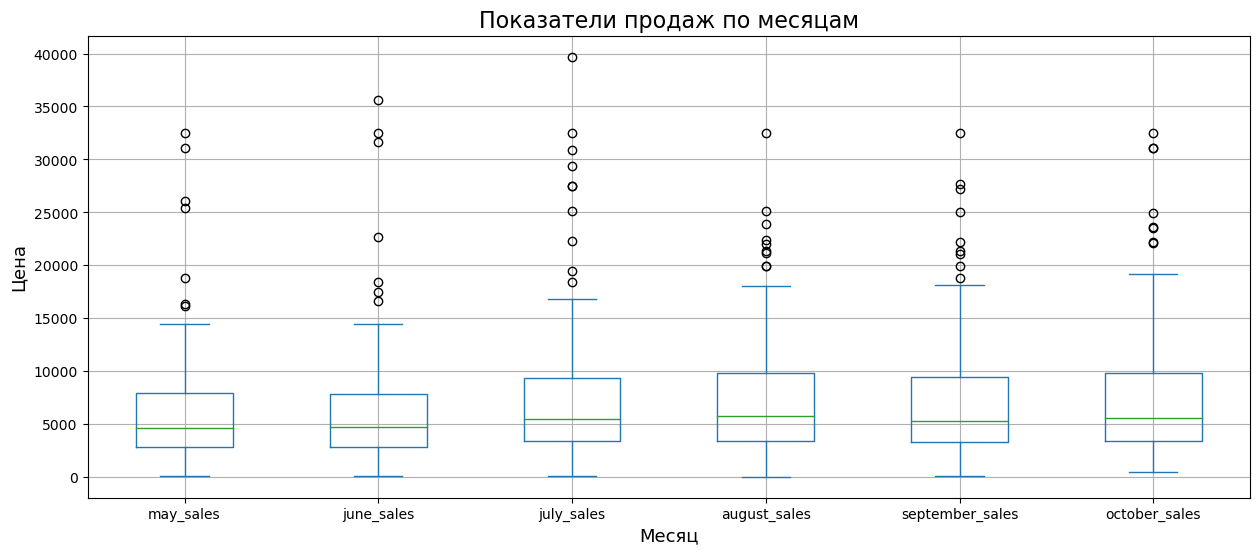

In [23]:
(
    all_period[['may_sales', 'june_sales', 'july_sales', 'august_sales', 'september_sales', 'october_sales']]
    .plot(figsize=(15, 6), kind='box', grid=True)
)
plt.xlabel('Месяц', fontsize=13)
plt.ylabel('Цена', fontsize=13)
plt.title('Показатели продаж по месяцам', fontsize=16)
plt.show()

По выбросам самые крупные заказы попадались в июне-июле.

По основным же покупкам лучше всего показал себя август: у него самая большая медиана и верхний квартиль - то есть, 75% заказов были около 6000 и выше. По нижнему квартилю он сопоставим с остальными месяцами.

В целом, заметно что с июля включительно суммы заказов имеют тенденцию к росту - медиана, и оба квартиля в июле, августе, сентябре и октябре выше, чем в мае-июне.

Также, выпонила отдельный график под июль, на случай если под "*рассматриваемым периодом*" имелся ввиду он:

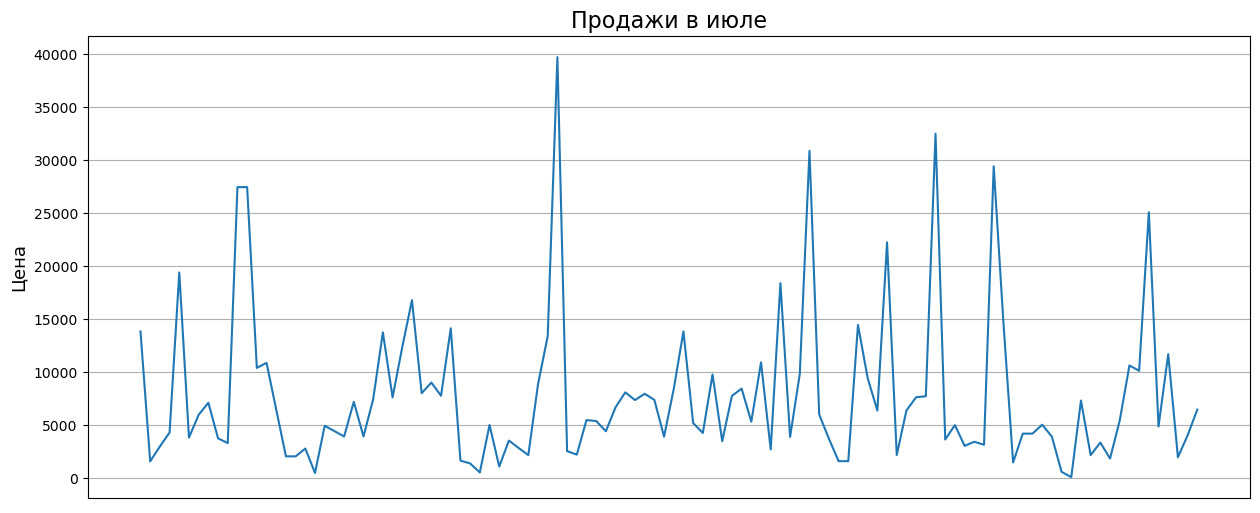

In [24]:
all_period['july_sales'].plot(figsize=(15, 6), grid=True)
plt.xticks([])
plt.ylabel('Цена', fontsize=13)
plt.title('Продажи в июле', fontsize=16)
plt.show()

Ось Х убрала тут за неинформативностью - в ней отражались индексы, по которым выстроились заказы.

Если предположить, что заказы в базе формируются по мере своего поступления, то есть индексы идут от начала июля к концу июля, то в первой половине июля видим тенденцию к сравнительно небольшим продажам с периодическими всплесками. Ближе к середине месяца случился всплеск на 40 тыс. После него был некоторый спад, но ближе к концу июля крупные заказы стали встречаться чаще.

**3. Кто из менеджеров привлек для компании больше всего денежных средств в сентябре 2021?**

На этот вопрос тоже ответим графиком.

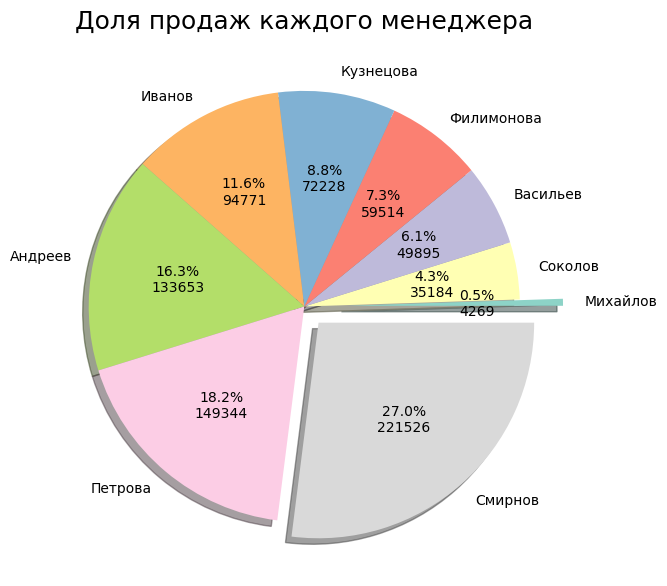

In [25]:
# группируем данные по каждому менеджеру:
shares = september.groupby('sale')['september_sales'].sum().sort_values(ascending=True)

def func(pct, allvals): # для вывода не только %, но и значений
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n{absolute:d}"

# рисуем график:
fig = plt.figure(figsize =(7, 7))
plt.pie(shares.values, labels = shares.index, autopct=lambda pct: func(pct, shares.values), shadow=True, 
        colors=sns.color_palette('Set3'), explode=[0.2, 0, 0, 0, 0, 0, 0, 0, 0.1])

plt.title("Доля продаж каждого менеджера", fontsize=18)
plt.show()

Видим, что с продажами в сентябре лучше всех справился Смирнов. На втором месте Петрова, а на третьем - Андреев.

**Какой тип сделок (новая/текущая) был преобладающим в октябре 2021?**

Тоже построим график, который наглядно покажет преобладание того или иного типа сделки:

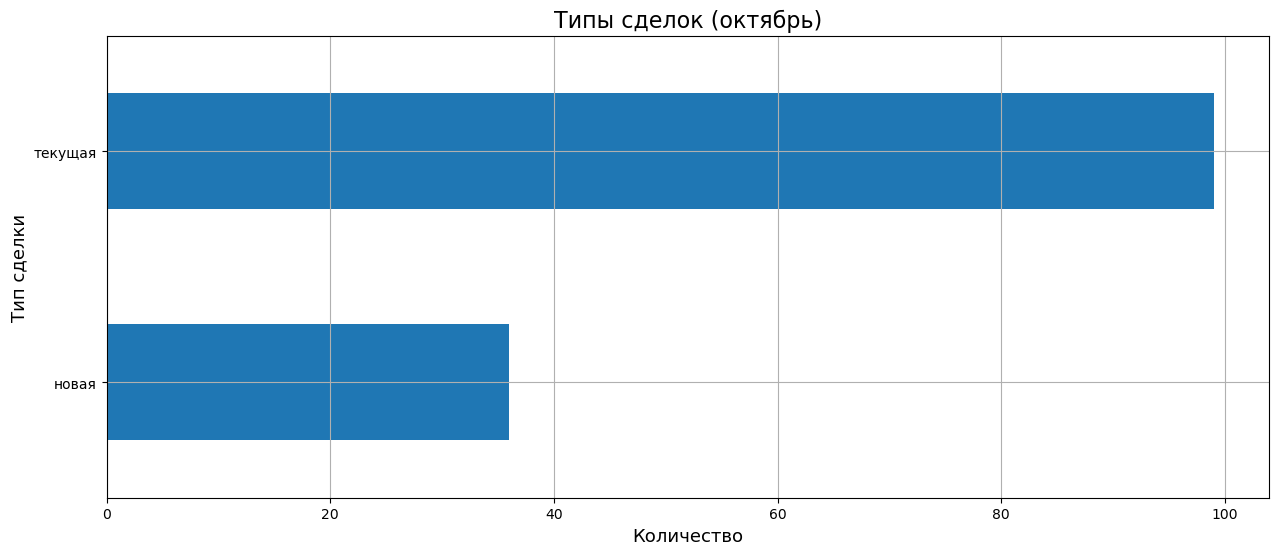

In [26]:
october.groupby('new_current')['new_current'].count().plot(kind='barh', figsize=(15, 6), grid=True)
plt.xlabel('Количество', fontsize=13)
plt.ylabel('Тип сделки', fontsize=13)
plt.title('Типы сделок (октябрь)', fontsize=16)
plt.show()

Большая часть сделок (почти 100) имеют тип "текущая". Новых сделок в почти 3 раза меньше.

**Сколько оригиналов договора по майским сделкам было получено в июне 2021?**

In [27]:
print('В июне 2021-го по майским сделкам было получено', may.query('month == 6 and document =="оригинал"')['document'].count(),
      'оригиналов договоров.')

В июне 2021-го по майским сделкам было получено 76 оригиналов договоров.


### Исследование. Часть с заданием:

За каждую заключенную сделку менеджер получает бонус, который рассчитывается
следующим образом.
1) За новые сделки менеджер получает 7 % от суммы, при условии, что статус
оплаты «ОПЛАЧЕНО», а также имеется оригинал подписанного договора с
клиентом (в рассматриваемом месяце).

2) За текущие сделки менеджер получает 5 % от суммы, если она больше 10 тыс.,
и 3 % от суммы, если меньше. При этом статус оплаты может быть любым,
кроме «ПРОСРОЧЕНО», а также необходимо наличие оригинала подписанного
договора с клиентом (в рассматриваемом месяце).

Бонусы по сделкам, оригиналы для которых приходят позже рассматриваемого
месяца, считаются остатком на следующий период, который выплачивается по мере
прихода оригиналов. Вычислите остаток каждого из менеджеров на 01.07.2021.

По условию получается, что чтобы вычислить остаток для каждого менеджера по состоянию на июль, нам нужно взять все их продажи за май и июнь, по которым оргинал договора пришел позже, чем в эти месяца. Для этого выполним следующее:

Для начала склеим датафрейм с данными продаж за май и июнь:

In [28]:
june_may = pd.concat([may, june])
june_may

,client_id,may_sales,status,sale,new_current,document,receiving_date,month,june_sales
1,6,11693.7,ВНУТРЕННИЙ,-,-,-,-,-,NaN
2,14,5452.7,ОПЛАЧЕНО,Петрова,новая,оригинал,2021-07-26 00:00:00,7,NaN
3,15,13991.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00,6,NaN
4,16,719.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00,6,NaN
5,18,4253.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-07-07 00:00:00,7,NaN
...,...,...,...,...,...,...,...,...,...
253,281,NaN,ОПЛАЧЕНО,Селиванов,текущая,оригинал,2021-07-22 00:00:00,7,5733.7
254,282,NaN,ОПЛАЧЕНО,Селиванов,новая,оригинал,2021-07-16 00:00:00,7,953.7
255,284,NaN,ПРОСРОЧЕНО,Филимонова,текущая,оригинал,2021-09-08 00:00:00,9,8823.7
256,286,NaN,ОПЛАЧЕНО,Филимонова,текущая,оригинал,2021-07-22 00:00:00,7,3453.7


Получили один датафрейм. Но то, что продажи по июню и маю идут отдельно, не совсем удобно. "Просуммируем" столбцы `may_sales` и `june_sales` (цифры останутся те же, так как колонки не пересекаются по индексам), чтобы суммы продаж оказались в одном столбце:

In [29]:
june_may['sum_sales'] = june_may.loc[:,['may_sales', 'june_sales']].sum(axis=1)
june_may

,client_id,may_sales,status,sale,new_current,document,receiving_date,month,june_sales,sum_sales
1,6,11693.7,ВНУТРЕННИЙ,-,-,-,-,-,NaN,11693.7
2,14,5452.7,ОПЛАЧЕНО,Петрова,новая,оригинал,2021-07-26 00:00:00,7,NaN,5452.7
3,15,13991.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00,6,NaN,13991.7
4,16,719.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00,6,NaN,719.7
5,18,4253.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-07-07 00:00:00,7,NaN,4253.7
...,...,...,...,...,...,...,...,...,...,...
253,281,NaN,ОПЛАЧЕНО,Селиванов,текущая,оригинал,2021-07-22 00:00:00,7,5733.7,5733.7
254,282,NaN,ОПЛАЧЕНО,Селиванов,новая,оригинал,2021-07-16 00:00:00,7,953.7,953.7
255,284,NaN,ПРОСРОЧЕНО,Филимонова,текущая,оригинал,2021-09-08 00:00:00,9,8823.7,8823.7
256,286,NaN,ОПЛАЧЕНО,Филимонова,текущая,оригинал,2021-07-22 00:00:00,7,3453.7,3453.7


Столбцы `may_sales` и `june_sales` удалим за ненужностью:

In [30]:
june_may = june_may.drop(['may_sales', 'june_sales'], axis=1)
june_may.head(5)

,client_id,status,sale,new_current,document,receiving_date,month,sum_sales
1,6,ВНУТРЕННИЙ,-,-,-,-,-,11693.7
2,14,ОПЛАЧЕНО,Петрова,новая,оригинал,2021-07-26 00:00:00,7,5452.7
3,15,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00,6,13991.7
4,16,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00,6,719.7
5,18,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-07-07 00:00:00,7,4253.7


Вверху датафрейма есть строка со статусом *ВНУТРЕННИЙ*. В её столбце month строковое значение "-", которое не даст провести нужные операции. Отфильтруем его:

In [31]:
june_may = june_may.query('month !="-"')

Теперь из этого датафрейма выделим всё, что подходит по условию для 7%:
- тип "новая";
- статус "оплачено";

Но получение оригинала отметим как позже июня - так у нас останутся только сделки, по которым оригинал пришел только в июле или позже, а значит все бонусы по этим майско-июньским сделкам первоначально перенеслись на июль.

In [32]:
seven_percent = (
    june_may.query('status == "ОПЛАЧЕНО" and new_current == "новая" and month > 6')
    .groupby('sale')['sum_sales'].sum()
    .reset_index()
)

seven_percent

,sale,sum_sales
0,Васильев,2678.7
1,Петрова,41106.4
2,Селиванов,61955.9
3,Смирнов,3053.7
4,Филимонова,10392.4


Сразу же посчитаем % от продаж, который должны менеджеру из этой таблички:

In [33]:
seven_percent['sum_sales'] = seven_percent['sum_sales'] / 100 * 7
seven_percent

,sale,sum_sales
0,Васильев,187.509
1,Петрова,2877.448
2,Селиванов,4336.913
3,Смирнов,213.759
4,Филимонова,727.468


Для бонусов с 5% отбираем строки, где:
- тип "текущая";
- сумма больше 10 тыс.;
- статус любой, кроме просрочено;
- месяц получения оригинала тоже > 6.

In [34]:
five_percent = (
    june_may.query('sum_sales > 10000 and status != "ПРОСРОЧЕНО" and new_current == "текущая" and month > 6')
    .groupby('sale')['sum_sales'].sum()
    .reset_index()
)
five_percent

,sale,sum_sales
0,Андреев,42825.10
1,Иванов,74853.40
2,Кузнецова,12639.76
3,Петрова,45797.10
4,Смирнов,96951.00


Считаем 5% от продаж:

In [35]:
five_percent['sum_sales'] = five_percent['sum_sales'] / 100 * 5
five_percent

,sale,sum_sales
0,Андреев,2141.255
1,Иванов,3742.670
2,Кузнецова,631.988
3,Петрова,2289.855
4,Смирнов,4847.550


Вырезаем сделки, где менеджерам причитается 3%:
- тип "текущая";
- сумма меньше 10 тыс.;
- статус любой, кроме просрочено;
- оригинал, опять же, не в мае и не в июне.

In [36]:
three_percent = (
    june_may.query('sum_sales < 10000 and status != "ПРОСРОЧЕНО" and new_current == "текущая" and month > 6')
    .groupby('sale')['sum_sales'].sum()
    .reset_index()
)
three_percent

,sale,sum_sales
0,Андреев,60451.19
1,Васильев,28318.00
2,Иванов,74959.40
3,Кузнецова,128832.07
4,Петрова,186781.48
5,Селиванов,32025.90
6,Смирнов,78017.10
7,Соколов,8973.70
8,Филимонова,53016.33


Считаем 3% от продаж:

In [37]:
three_percent['sum_sales'] = three_percent['sum_sales'] / 100 * 3
three_percent

,sale,sum_sales
0,Андреев,1813.5357
1,Васильев,849.5400
2,Иванов,2248.7820
3,Кузнецова,3864.9621
4,Петрова,5603.4444
5,Селиванов,960.7770
6,Смирнов,2340.5130
7,Соколов,269.2110
8,Филимонова,1590.4899


Теперь сведем все это в один датафрейм, смержив через outer, чтобы попали все строки:

In [38]:
july_balance = (three_percent.merge(five_percent[['sum_sales', 'sale']], on='sale', how='outer'))
july_balance = (july_balance.merge(seven_percent[['sum_sales', 'sale']], on='sale', how='outer'))
july_balance

,sale,sum_sales_x,sum_sales_y,sum_sales
0,Андреев,1813.5357,2141.255,NaN
1,Васильев,849.5400,NaN,187.509
2,Иванов,2248.7820,3742.670,NaN
3,Кузнецова,3864.9621,631.988,NaN
4,Петрова,5603.4444,2289.855,2877.448
5,Селиванов,960.7770,NaN,4336.913
6,Смирнов,2340.5130,4847.550,213.759
7,Соколов,269.2110,NaN,NaN
8,Филимонова,1590.4899,NaN,727.468


Теперь просуммируем все эти бонусы в один новый столбец, в результате чего получим полный остаток для каждого из менеджеров:

In [39]:
july_balance['balance'] = july_balance.loc[:,['sum_sales_x', 'sum_sales_y', 'sum_sales']].sum(axis=1).round(2)
july_balance

,sale,sum_sales_x,sum_sales_y,sum_sales,balance
0,Андреев,1813.5357,2141.255,NaN,3954.79
1,Васильев,849.5400,NaN,187.509,1037.05
2,Иванов,2248.7820,3742.670,NaN,5991.45
3,Кузнецова,3864.9621,631.988,NaN,4496.95
4,Петрова,5603.4444,2289.855,2877.448,10770.75
5,Селиванов,960.7770,NaN,4336.913,5297.69
6,Смирнов,2340.5130,4847.550,213.759,7401.82
7,Соколов,269.2110,NaN,NaN,269.21
8,Филимонова,1590.4899,NaN,727.468,2317.96


In [40]:
july_balance = july_balance.drop(['sum_sales_x', 'sum_sales_y', 'sum_sales'], axis=1)

И теперь мы видим, что по состоянию на июль у каждого из менеджеров был такой вот остаток бонусов, которые не выплатили, так как оригиналы договоров еще не дошли:

In [41]:
july_balance

,sale,balance
0,Андреев,3954.79
1,Васильев,1037.05
2,Иванов,5991.45
3,Кузнецова,4496.95
4,Петрова,10770.75
5,Селиванов,5297.69
6,Смирнов,7401.82
7,Соколов,269.21
8,Филимонова,2317.96
